In [2]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [3]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [4]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [5]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
#                     'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

In [6]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores
N_CORES = 16


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = '../input/m5-simple-fe/grid_part_1.pkl'
PRICE    = '../input/m5-simple-fe/grid_part_2.pkl'
CALENDAR = '../input/m5-simple-fe/grid_part_3.pkl'
LAGS     = '../input/m5-lags-features/lags_df_28.pkl'
MEAN_ENC = '../input/m5-custom-features/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
AUX_MODELS = '../input/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [7]:
########################### Aux Models
# If you don't want to wait hours and hours
# to have result you can train each store 
# in separate kernel and then just join result.

# If we want to use pretrained models we can 
## skip training 
## (in our case do dummy training
##  to show that we are good with memory
##  and you can safely use this (all kernel) code)
if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Here is some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

#Train CA_2
#[100]	valid_0's rmse: 1.88949
#[200]	valid_0's rmse: 1.84767
#[300]	valid_0's rmse: 1.83653
#[400]	valid_0's rmse: 1.82909
#[500]	valid_0's rmse: 1.82265
#[600]	valid_0's rmse: 1.81725
#[700]	valid_0's rmse: 1.81252
#[800]	valid_0's rmse: 1.80736
#[900]	valid_0's rmse: 1.80242
#[1000]	valid_0's rmse: 1.79821
#[1100]	valid_0's rmse: 1.794
#[1200]	valid_0's rmse: 1.78973
#[1300]	valid_0's rmse: 1.78552
#[1400]	valid_0's rmse: 1.78158

In [47]:
########################### Train Models
#################################################################################
for store_id in STORES_IDS:
#     print('Train', store_id)
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    print('Train', store_id, train_mask.astype(int).sum())
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+'.pkl')
    del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 100,
                          )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(model_name, 'wb'))

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Train CA_1 4702895
[100]	valid_0's rmse: 2.02468
[200]	valid_0's rmse: 2.00555
[300]	valid_0's rmse: 1.99549
[400]	valid_0's rmse: 1.98766
[500]	valid_0's rmse: 1.98242
[600]	valid_0's rmse: 1.97619
[700]	valid_0's rmse: 1.97038
[800]	valid_0's rmse: 1.96458
[900]	valid_0's rmse: 1.95973
[1000]	valid_0's rmse: 1.95427
[1100]	valid_0's rmse: 1.94938
[1200]	valid_0's rmse: 1.94611
[1300]	valid_0's rmse: 1.94191
[1400]	valid_0's rmse: 1.9365
Train CA_2 4275776
[100]	valid_0's rmse: 1.89205
[200]	valid_0's rmse: 1.84924
[300]	valid_0's rmse: 1.838
[400]	valid_0's rmse: 1.83037
[500]	valid_0's rmse: 1.82428
[600]	valid_0's rmse: 1.81818
[700]	valid_0's rmse: 1.81269
[800]	valid_0's rmse: 1.80777
[900]	valid_0's rmse: 1.80331
[1000]	valid_0's rmse: 1.79889
[1100]	valid_0's rmse: 1.79437
[1200]	valid_0's rmse: 1.79062
[1300]	valid_0's rmse: 1.78612
[1400]	valid_0's rmse: 1.78248
Train CA_3 4671941
[100]	valid_0's rmse: 2.50392
[200]	valid_0's rmse: 2.45865
[300]	valid_0's rmse: 2.43628
[400]	

In [55]:
########################### Predict
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        USE_AUX = False
        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
    
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

Predict | Day: 1


In [8]:
for store_id in STORES_IDS:
        
    # Read all our models and make predictions
    # for each day/store pairs
    model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
    model_path = AUX_MODELS + model_path

    estimator = pickle.load(open(model_path, 'rb'))

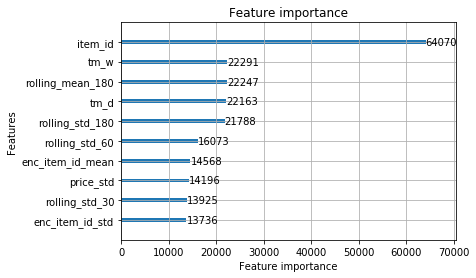

In [11]:
lgb.plot_importance(estimator, max_num_features=10)

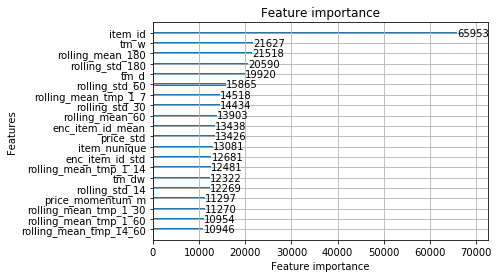

In [54]:
lgb.plot_importance(estimator, max_num_features=20)

In [35]:
########################### Export
#################################################################################
# Reading competition sample submission and
# merging our predictions
# As we have predictions only for "_validation" data
# we need to do fillna() for "_evaluation" items
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
submission.to_csv('submission_v'+str(VER)+'.csv', index=False)

In [ ]:
# Summary

# Of course here is no magic at all.
# No "Novel" features and no brilliant ideas.
# We just carefully joined all
# our previous fe work and created a model.

# Also!
# In my opinion this strategy is a "dead end".
# Overfits a lot LB and with 1 final submission 
# you have no option to risk.


# Improvement should come from:
# Loss function
# Data representation
# Stable CV
# Good features reduction strategy
# Predictions stabilization with NN
# Trend prediction
# Real zero sales detection/classification


# Good kernels references 
## (the order is random and the list is not complete):
# https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
# https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern
# https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
# https://www.kaggle.com/sibmike/m5-out-of-stock-feature
# https://www.kaggle.com/mayer79/m5-forecast-attack-of-the-data-table
# https://www.kaggle.com/yassinealouini/seq2seq
# https://www.kaggle.com/kailex/m5-forecaster-v2
# https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost


# Features were created in these kernels:
## 
# Mean encodings and PCA options
# https://www.kaggle.com/kyakovlev/m5-custom-features
##
# Lags and rolling lags
# https://www.kaggle.com/kyakovlev/m5-lags-features
##
# Base Grid and base features (calendar/price/etc)
# https://www.kaggle.com/kyakovlev/m5-simple-fe


# Personal request
# Please don't upvote any ensemble and copypaste kernels
## The worst case is ensemble without any analyse.
## The best choice - just ignore it.
## I would like to see more kernels with interesting and original approaches.
## Don't feed copypasters with upvotes.

## It doesn't mean that you should not fork and improve others kernels
## but I would like to see params and code tuning based on some CV and analyse
## and not only on LB probing.
## Small changes could be shared in comments and authors can improve their kernel.

## Feel free to criticize this kernel as my knowlege is very limited
## and I can be wrong in code and descriptions. 
## Thank you.

In [12]:
submission = pd.read_csv('submission_v1.csv')

In [14]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.989985,0.985802,0.985802,0.983716,0.988537,1.008891,1.010170,0.991269,0.991269,...,0.995350,1.008506,1.010170,0.992496,0.985802,0.985802,0.985802,0.995350,1.010170,1.008750
1,HOBBIES_1_002_CA_1_validation,0.949197,0.949197,0.950753,0.953089,0.954706,0.965016,0.965016,0.954713,0.958543,...,0.961995,0.972333,0.980279,0.965810,0.964250,0.964250,0.964250,0.964250,0.987260,0.987260
2,HOBBIES_1_003_CA_1_validation,0.962125,0.964250,0.965650,0.986646,0.969356,0.981614,0.985522,0.966385,0.966385,...,0.972439,0.997253,0.985522,0.967893,0.972749,0.975493,0.975493,0.990717,0.992245,0.992245
3,HOBBIES_1_004_CA_1_validation,1.045364,1.024167,1.024167,1.024167,1.039044,1.074784,1.074784,1.048719,1.044982,...,1.023681,1.048811,1.048811,1.029137,1.029137,1.029137,1.029137,1.029137,1.048811,1.048811
4,HOBBIES_1_005_CA_1_validation,1.001290,0.993959,1.000252,1.000252,1.003778,1.024652,1.029838,1.006283,1.007435,...,0.999820,1.022905,1.023732,0.998473,0.993667,0.993667,0.993667,0.997170,1.022409,1.022409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
ori_submission = pd.read_csv('ori_submission_v1.csv')

In [30]:
ori_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.754956,0.710293,0.723041,0.757371,0.930978,1.017402,1.149758,0.850865,0.856534,...,0.770908,0.943370,0.963763,0.812957,0.757883,0.723716,0.773000,0.877107,1.034379,0.944918
1,HOBBIES_1_002_CA_1_validation,0.191938,0.187140,0.182817,0.181085,0.222433,0.264552,0.295977,0.237515,0.222527,...,0.207496,0.222726,0.225074,0.194898,0.177903,0.185044,0.178583,0.192817,0.232550,0.247974
2,HOBBIES_1_003_CA_1_validation,0.445837,0.421734,0.418613,0.417528,0.580683,0.742513,0.761937,0.493187,0.496076,...,0.549582,0.700338,0.704256,0.445749,0.417246,0.445126,0.476210,0.608853,0.724363,0.684994
3,HOBBIES_1_004_CA_1_validation,1.622182,1.276876,1.333453,1.523020,1.917593,2.878792,3.189502,1.768638,1.480806,...,1.861259,2.673030,3.245865,1.695736,1.450723,1.448565,1.424861,2.055415,3.144716,3.403936
4,HOBBIES_1_005_CA_1_validation,0.943043,0.853174,0.860399,0.940414,1.067462,1.469891,1.518171,0.978536,0.969054,...,1.039325,1.597230,1.598630,1.072630,0.863821,0.962907,0.931099,1.103105,1.573273,1.517332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
